# Jet, Thickness, SLP, and Moisture Map
http://www.atmos.albany.edu/student/heathera/2016.html
 The Thickness, SLP, and Moisture map contains
    - 250-hPa wind speed (m s^-1, shaded according to the color bar)
    - 1000-500-hPa thickness (dashed contours every 6 dam)
    - SLP (solid contours every 4 hPa)
    - total precipitable water (mm, shaded according to gray scale)



 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]
    - name = 'Geopotential',               shortName = 'z',      [m^2 s^-2]
    - name = 'Mean sea level pressure',    shortName = 'msl',    [Pa]
    - name = 'Total column water vapour',  shortName = 'tcwv',   [kg m-2] equal [mm], since the density of water is 1000 kg m^-3



https://software.ecmwf.int/wiki/display/CKB/How+to+plot+GRIB+files+with+Python+and+matplotlib

In [1]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
from scipy import ndimage
from datetime import date
import calendar




In [2]:
year = '2016'
mon = '12'
day = '25'
time = '18'

In [3]:
### Define colorbar colors
champ = 255.
blue = np.array([1,74,159])/champ           # for the date


# tot. precipitable water (grey scale)
#no1 = np.array([255,255,255])/champ
no1 = np.array([245,245,245])/champ

#no2 = np.array([231,231,231])/champ
no2 = np.array([222,222,222])/champ

#no3 = np.array([201,201,201])/champ
no3 = np.array([193,193,193])/champ

#no4 = np.array([171,171,171])/champ
no4 = np.array([164,164,164])/champ

#no5 = np.array([140,140,140])/champ
no5 = np.array([135,135,135])/champ

#no6 = np.array([110,110,110])/champ
no6 = np.array([106,106,106])/champ

#no7 = np.array([80,80,80])/champ
no7 = np.array([77,77,77])/champ

#no8 = np.array([72,72,72])/champ
#no9 = np.array([56,56,56])/champ

# 250 hPa wind speed (colored scale)
no11 = np.array([255,255,255])/champ
no12 = np.array([196,225,255])/champ
no13 = np.array([131,158,255])/champ
no14 = np.array([255,209,177])/champ
no15 = np.array([255,118,86])/champ
no16 = np.array([239,102,178])/champ
no17 = np.array([243,0,146])/champ

In [4]:
def opengrib(yyyy, mm, dd, tt, pm, path):
    grib = '%s/%s/param_%s_%s%s%s_%s00.grib' % (path,pm,pm,yyyy,mm,dd,tt)
    grbs = pygrib.open(grib)
    return(grbs);

In [5]:
def selectgrb(grbs, sN, tOL, lv):
    val = grbs.select()[0]
    val = grbs.select(shortName = sN, typeOfLevel = tOL, level = lv)[0]
    val = val.values
    return(val);

In [6]:
def shiftgrb(grb,val):
    lat,lon = grb.latlons()
    lons = lon[0,:]
    val,lons = shiftgrid(180., val, lons, start = False)
    lats = lat[:,0]
    
    lons,lats = np.meshgrid(lons,lats)
    plons,plats = m(lons,lats)
    return(plons,plats,val);

In [7]:
### OPEN FILES
path = '../test_dataECMWF/SCA/pl'

### Wind
parameter = 'uv'
grbsUV = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Geopotential
parameter = 'z'
grbsZ = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)


path = '../test_dataECMWF/SCA/sfc'
### Mean Sea Level Pressure
parameter = 'msl'
grbsMSL = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Precipitable Water
parameter = 'tcwv'
grbsPW = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)




In [8]:
#print('U, V component of wind:', grbUV.dataDate,grbUV.dataTime)     # gives the date and forecast time
#print('Geopotential:', grbZ.dataDate,grbZ.dataTime)
#print('MSL:', grbMSL.dataDate,grbMSL.dataTime)   
#print('Precipitable water:', grbPW.dataDate,grbPW.dataTime)

In [9]:
### print an inventory of the file
# U, V component of wind
#grbsUV.seek(0)
#for grbUV in grbsUV:
#    print(grbUV)


In [10]:
### GET FILE DATA
tOL = 'isobaricInhPa'
lv = 250
## Wind
# U component of wind
sN = 'u'
grbUV = grbsUV.select()[0]
wind_u = selectgrb(grbsUV, sN, tOL, lv)
# V component of wind
sN = 'v'
wind_v = selectgrb(grbsUV, sN, tOL, lv)

In [11]:
### Calculate wind speed
Uabs = np.sqrt(wind_u**2 + wind_v**2)


In [12]:
## Geopotential

# 1000 hPa
sN = 'z'
lv = 1000
grbZ = grbsZ.select()[0]
G1000 = selectgrb(grbsZ, sN, tOL, lv)

# 500 hPa
lv = 500
G500 = selectgrb(grbsZ, sN, tOL, lv)

In [13]:
### convert Geopotential to height
# https://en.wikipedia.org/wiki/Geopotential
a = 6.378*10**6     # average radius of the earth  [m]
G = 6.673*10**(-11) # gravitational constant       [Nm2/kg2]
ma = 5.975*10**24   #  mass of the earth           [kg]

Z1000 = (-a**2 * G1000)/(a*G1000 - G* ma) 
Z500 = (-a**2 * G500)/(a*G500 - G* ma) 

Z = (Z500 - Z1000)/10


In [14]:
## Mean sea level pressure
tOL = 'surface'
lv = 0
sN = 'msl'
grbMSL = grbsMSL.select()[0]
MSL = selectgrb(grbsMSL, sN, tOL, lv)
#print(MSL)

In [15]:
### converst MSL from Pa --> hPa
MSL = 0.01 * MSL
#print(MSL)


In [16]:
## Total colum water vapour
sN = 'tcwv'
grbPW = grbsPW.select()[0]
PW = selectgrb(grbsPW, sN, tOL, lv)

In [17]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-80., urcrnrlon=50., \
            llcrnrlat=15.,urcrnrlat=75., \
            resolution='l')

In [18]:
### Latitudes, Longitudes and shiftgrid
plonsUV,platsUV, Uabs = shiftgrb(grbUV,Uabs)
plonsZ,platsZ, Z = shiftgrb(grbZ,Z)
plonsMSL,platsMSL, MSL = shiftgrb(grbMSL,MSL)

In [19]:
plonsPW,platsPW, PW = shiftgrb(grbPW,PW)

In [20]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]



### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html



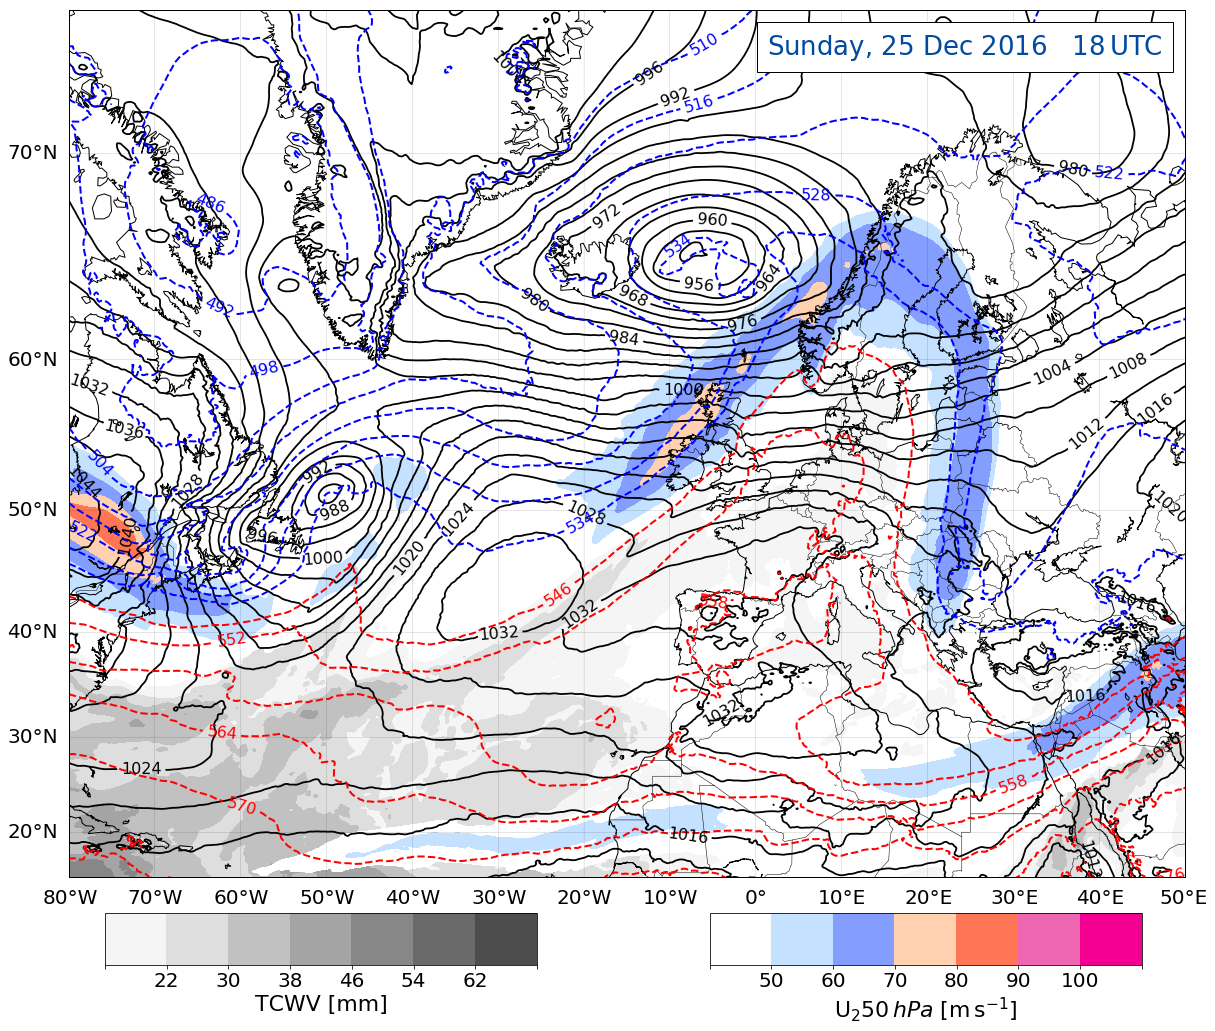

In [21]:
### PLOT FIGURE
fig = plt.figure(figsize = (20,14.15))
ax = fig.add_subplot(1,1,1)

### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,10.),labels=[1,0,0,0],fontsize=20,linewidth=0.2)

### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,0,1],fontsize=20,linewidth=0.2)

### Draw Map
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
#m.fillcontinents(color='grey',alpha=0.1)


### Plot contour lines for precipitable water
PWlevs = np.arange(14.,78.,8.)
Pmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])
normP = colors.BoundaryNorm(boundaries = PWlevs, ncolors=Pmap.N)
cp = m.contourf(plonsPW, platsPW, PW, PWlevs, norm = normP, cmap = Pmap)


### Plot contour lines for 250-hPa wind and fill
Ulevels = np.arange(40,120,10)
Umap = colors.ListedColormap([no11, no12, no13, no14, no15, no16, no17])
norm = colors.BoundaryNorm(boundaries = Ulevels, ncolors=Umap.N)
cs = m.contourf(plonsUV, platsUV, Uabs, Ulevels, norm = norm, cmap=Umap)

### Plot MSL pressure every 4 hPa
clevs = np.arange(900,1100.,4.)
cc = m.contour(plonsMSL, platsMSL, MSL, clevs, colors='k', linewidths = 1.8)
plt.clabel(cc, fontsize=16, inline = 1, fmt ='%1.0f')

### Plot the 1000-500 hPa thickness
thlevs1 = np.arange(450., 540., 6.)
thlevs2 = np.arange(546., 650., 6.)

cth1 = m.contour(plonsZ, platsZ, Z, thlevs1, colors='b', linewidths = 2., linestyles = 'dashed')
cth2 = m.contour(plonsZ, platsZ, Z, thlevs2, colors='r', linewidths = 2., linestyles = 'dashed')
plt.clabel(cth1, fontsize = 16, inline = 1, fmt = '%1.0f')
plt.clabel(cth2, fontsize = 16, inline = 1, fmt = '%1.0f')


### Add Colorbar
cbaxes = fig.add_axes([0.57, 0.05, 0.3, 0.045]) 
cbar = plt.colorbar(cs,orientation='horizontal', cax = cbaxes)
cbar.ax.set_xlabel('U$_250\,hPa$ [m$\,$s$^{-1}$]',fontsize = 22)
cbar.ax.set_xticklabels(['', '50', '60', '70', '80', '90', '100'])  # horizontal colorbar
cbar.ax.tick_params(labelsize=20)


cbaxesP = fig.add_axes([0.15, 0.05, 0.3, 0.045]) 
cbarP = plt.colorbar(cp,orientation='horizontal', cax = cbaxesP)
cbarP.ax.set_xlabel('TCWV [mm]',fontsize = 22)
cbarP.ax.set_xticklabels(['', '22', '30', '38', '46', '54', '62'])  # horizontal colorbar
cbarP.ax.tick_params(labelsize =20)

### Add Textbox
ax.text(0.98,0.94, '%s, %s %s %s   %s$\,$UTC' %(calday, day, calmon, year, time),
            verticalalignment = 'bottom',  horizontalalignment='right',
            transform = ax.transAxes,
            color =blue, fontsize=26,
            bbox={'facecolor':'white','alpha':1., 'pad':10})

### Add Title
#    fig.suptitle('Jet, Thickness, SLP, and Moisture', fontsize=16, fontweight='bold') 
#    ax.set_title('MSLP (solid contours every 4$\,$hPa), \n \
#    250$\,$hPa wind speed (m$\,$s$^{-1}$, shaded according to the color bar), \n \
#    1000-500$\,$hPa thickness (dashed contours every 6 dam), \n \
#    total precipitable water (mm, shaded according to gray scale)', \
#            fontsize=13)
#plt.title('') 


### Save
plt.savefig('../synoptic_figs/Geopot_Jet/%s%s%s_%s.png' % (year, mon, day,time),
            orientation = 'landscape', papertype = 'a4' )
## with header
#    plt.savefig('../synoptic_figs/Jet_Thick_SLP/%s%s%s_%s_header.png' % (year, mon, day,time))



###
plt.show()
plt.close()